<font size=10>Laboratory Assignment 3.1</font>

# Introduction
In this laboratory, we will cover the basic element of programming using a map-reduce methodology. For that purpose, we will be using Apache Spark as a reference, but bear in mind that similar frameworks exists and principles can be extrapolated.

## Some concepts and facts

- Spark is a distributed computing platform that operates on a cluster. Like MPI, we expect that nodes does NOT share a memory space but they are connected in high-speed dedicated network. Distributed filesystems that work over the network are extremely useful.

- It is considered the next generation of previous map-reduce standard Apache Hadoop. Main difference is thought to be the use of the memory instead of disk for intermediate operations, but there are many more improvements.

- It is built on Java. Despite this, it can be programmed using Java, Scala, Python or R. The complete API can only be found in JVM-based languages but the most frequent one is PySpark, since people is reluctant to use JVM-based languages in data science. Indeed, since Hadoop was only available for Java, it is likely that some Java codes of Spark are adaptations of previous Hadoop codes.

- Resilient Distributed Dataset (RDD): the basic unit that is processed in Spark. Equivalent to a numpy array but distributed.

- RDD API usually exposes the low-level operations of Apache Spark, useful for preprocessing data but useless for data analytics

- For data analysis, Dataframe and Spark SQL is used. It relies on a pandas-alike API that even accepts SQL code (which may sound crazy and useless for developers, but many *old* data scientists and statisticians are really proficient in SQL but not in Python).

## How to install Spark in colab.

In [1]:
spark_version = "3.5.0"
hadoop_version = "3"

!apt-get update
!apt-get install openjdk-8-jdk-headless -qq # Install JVM v8
!wget -O spark-{spark_version}-bin-hadoop{hadoop_version}.tgz -q https://downloads.apache.org/spark/spark-{spark_version}/spark-{spark_version}-bin-hadoop{hadoop_version}.tgz # Download latest release. Update if necessary
!tar xf spark-{spark_version}-bin-hadoop{hadoop_version}.tgz # Unzip
!pip install pyspark # Well, the library itself
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/spark-{spark_version}-bin-hadoop{hadoop_version}"

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:8 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,131 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [555 kB]
Get:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,009 kB]
Get:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 

## How to initialize Spark

In [2]:
from pyspark.sql import SparkSession

APP_NAME = "CAP-lab3"
SPARK_URL = "local[*]"
spark = SparkSession.builder.appName(APP_NAME).master(SPARK_URL).getOrCreate()
sc = spark.sparkContext

# First Part: RDDs

## Basic operations

### Parallelize & collect

It creates a RDD out of a list or array. Second argument indicates the number of pieces of the RDD

In [3]:
array = sc.parallelize([1,2,3,4,5,6,7,8,9,10], 2)
array

ParallelCollectionRDD[0] at readRDDFromFile at PythonRDD.scala:289

In [4]:
import numpy as np
randomSamples = sc.parallelize(np.random.randn(100))
randomSamples

ParallelCollectionRDD[1] at readRDDFromFile at PythonRDD.scala:289

Cool, RDDs can not be printed...

Of course, RDDs can not be printed unless they are reduced

In [5]:
print(array.collect())
print(randomSamples.collect())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[-0.25014942671585233, 0.5639831155786905, -0.24284344766647997, -0.5240945221857672, -1.4626196166371364, -0.3678625440612429, 0.05733461153628847, -0.9845128813987676, -0.594860747923005, 0.1985473338519375, -0.35536847084019796, 0.02362980775907547, -0.6695000103241413, 0.8920110693493584, -1.6158749771649088, 1.4209517968177006, 1.1603169699194742, -1.1073323326018132, 0.06821024346347059, -1.1931768864369074, 0.22162770666197132, 1.4797860947206154, -1.1910495774623617, -1.0929579024972944, -1.2956556445971097, 0.4117727010031983, -0.25226758471882865, -1.8038304404009653, 2.1511464399095432, -0.5950288451002752, -1.3730711541145537, 0.8557622311401314, 0.03730813884291329, -0.25527758630868463, 1.9844249965624754, -2.109260348496825, 1.5054969237990652, 0.30432631936771504, -1.0179601698100575, -0.2236267261089719, -0.9821642241232685, 0.38477604883748767, -0.14029588431506756, 1.8175598339341847, 0.20466498125752572, -0.4123273340615243, 0.3436916

Spark uses lazy operations for everything, this means that nothing is evaluated until an action, a reduce operation normally, is performed. The basic reduce operation is collect, which returns the whole RDD (i.e. no reduction is performed).

### Other ways of loading data

In [6]:
import requests

request = requests.get("https://gist.githubusercontent.com/jsdario/6d6c69398cb0c73111e49f1218960f79/raw/8d4fc4548d437e2a7203a5aeeace5477f598827d/el_quijote.txt")
with open("elquijote.txt", "wb") as f:
  f.write(request.content)

In [7]:
quijote = sc.textFile("elquijote.txt")
quijote.take(10)

['DON QUIJOTE DE LA MANCHA',
 'Miguel de Cervantes Saavedra',
 '',
 'PRIMERA PARTE',
 'CAPÍTULO 1: Que trata de la condición y ejercicio del famoso hidalgo D. Quijote de la Mancha',
 'En un lugar de la Mancha, de cuyo nombre no quiero acordarme, no ha mucho tiempo que vivía un hidalgo de los de lanza en astillero, adarga antigua, rocín flaco y galgo corredor. Una olla de algo más vaca que carnero, salpicón las más noches, duelos y quebrantos los sábados, lentejas los viernes, algún palomino de añadidura los domingos, consumían las tres partes de su hacienda. El resto della concluían sayo de velarte, calzas de velludo para las fiestas con sus pantuflos de lo mismo, los días de entre semana se honraba con su vellori de lo más fino. Tenía en su casa una ama que pasaba de los cuarenta, y una sobrina que no llegaba a los veinte, y un mozo de campo y plaza, que así ensillaba el rocín como tomaba la podadera. Frisaba la edad de nuestro hidalgo con los cincuenta años, era de 

Here, you can see both a method to load a text file line per line and a another reduction operation.

In [8]:
quijote.take?

### Transformations

Let's review all the transformation that can be performed to data.

In [9]:
charsPerLine = quijote.map(lambda s: len(s))
allWords = quijote.flatMap(lambda s: s.split())
allWordsNoArticles = allWords.filter(lambda a: a.lower() not in ["el", "la"])
allWordsUnique = allWords.map(lambda s: s.lower()).distinct()
sampleWords = allWords.sample(withReplacement=True, fraction=0.2, seed=666)
weirdSampling = sampleWords.union(allWordsNoArticles.sample(False, fraction=0.3))

In [10]:
allWordsUnique.take(10)

['don',
 'mancha',
 'saavedra',
 'primera',
 'parte',
 '1:',
 'que',
 'condición',
 'y',
 'del']

--------


<font size=10 color=red>Assignment question</font>

Explain the use and purpose of each operation above.

Comment also on the size of the resulting RDD in terms of the size of the original RDD, e.g. if original RDD is of size $N$, then rdd.filter() is of size $K\leq N$

--------
Answer:
- map
- flatMap
- filter
- distinct
- sample
- union

----

 ### Actions



In [11]:
numLines = quijote.count()
numChars = charsPerLine.reduce(lambda a,b: a+b) # also charsPerLine.sum()
sortedWordsByLength = allWordsNoArticles.takeOrdered(10, key=lambda x: -len(x))
numLines, numChars, sortedWordsByLength

(2186,
 1036211,
 ['procuremos.Levántate,',
  'extraordinariamente,',
  'estrechísimamente,',
  'convirtiéndoseles',
  'entretenimientos,',
  'inadvertidamente.',
  'cortesísimamente',
  'Agredeciéronselo',
  'Pintiquiniestra,',
  'entretenimiento,'])

--------


<font size=10 color=red>Assignment question</font>

Explain the use and purpose of each action above.

Implement the count operation using reduce as the unique option. You can use transformations. Is it possible to achieve a solution without any transformation? Does it make sense?

--------
Answer:


----

## Key-Value RDDs

In [12]:
import re
allWords = allWords.flatMap(lambda w: re.sub(""";|:|\.|,|-|–|"|'|\s"""," ", w.lower()).split(" ")).filter(lambda a: len(a)>0)
allWords2 = sc.parallelize(requests.get("https://gist.githubusercontent.com/jsdario/9d871ed773c81bf217f57d1db2d2503f/raw/585de69b0631c805dabc6280506717943b82ba4a/el_quijote_ii.txt").iter_lines())
allWords2 = allWords2.flatMap(lambda w: re.sub(""";|:|\.|,|-|–|"|'|\s"""," ", w.decode("utf8").lower()).split(" ")).filter(lambda a: len(a)>0)

In [13]:
allWords.take(10), allWords2.take(10)

(['don',
  'quijote',
  'de',
  'la',
  'mancha',
  'miguel',
  'de',
  'cervantes',
  'saavedra',
  'primera'],
 ['don',
  'quijote',
  'de',
  'la',
  'mancha',
  'miguel',
  'de',
  'cervantes',
  'saavedra',
  'segunda'])

Next, we move to more interesting operations that involve key-value RDDs. Key-value RDDs are a special kind of RDDs where each is element is a tuple (K,V) where K is the key and V the value.

In [14]:
words = allWords.map(lambda e: (e,1))
words2 = allWords2.map(lambda e: (e,1))

words.take(10)

[('don', 1),
 ('quijote', 1),
 ('de', 1),
 ('la', 1),
 ('mancha', 1),
 ('miguel', 1),
 ('de', 1),
 ('cervantes', 1),
 ('saavedra', 1),
 ('primera', 1)]

### How to manipulate K-V RDDs

In [15]:
frequencies = words.reduceByKey(lambda a,b: a+b)
frequencies2 = words2.reduceByKey(lambda a,b: a+b)
frequencies.takeOrdered(10, key=lambda a: -a[1])

[('que', 10705),
 ('de', 9033),
 ('y', 8668),
 ('la', 5015),
 ('a', 4815),
 ('en', 4046),
 ('el', 3857),
 ('no', 3083),
 ('se', 2382),
 ('los', 2148)]

In [16]:
res = words.groupByKey().takeOrdered(10, key=lambda a: -len(a))
res # To see the content, res[i][1].data

[('don', <pyspark.resultiterable.ResultIterable at 0x78ce3de15ae0>),
 ('mancha', <pyspark.resultiterable.ResultIterable at 0x78ce3de14160>),
 ('saavedra', <pyspark.resultiterable.ResultIterable at 0x78ce3de16470>),
 ('primera', <pyspark.resultiterable.ResultIterable at 0x78ce3de15570>),
 ('parte', <pyspark.resultiterable.ResultIterable at 0x78ce3de15180>),
 ('1', <pyspark.resultiterable.ResultIterable at 0x78ce3de150f0>),
 ('que', <pyspark.resultiterable.ResultIterable at 0x78ce3de14b20>),
 ('condición', <pyspark.resultiterable.ResultIterable at 0x78ce3de15660>),
 ('y', <pyspark.resultiterable.ResultIterable at 0x78ce3de15900>),
 ('del', <pyspark.resultiterable.ResultIterable at 0x78ce3de149a0>)]

In [17]:
joinFreq = frequencies.join(frequencies2)
joinFreq.take(10)

[('don', (1072, 1606)),
 ('mancha', (50, 101)),
 ('saavedra', (2, 1)),
 ('primera', (39, 55)),
 ('parte', (178, 158)),
 ('1', (1, 1)),
 ('que', (10705, 10040)),
 ('condición', (33, 39)),
 ('y', (8668, 9650)),
 ('del', (1128, 1344))]

In [18]:
joinFreq.map(lambda e: (e[0], (e[1][0] - e[1][1])/(e[1][0] + e[1][1]))).takeOrdered(10, lambda v: -v[1]), joinFreq.map(lambda e: (e[0], (e[1][0] - e[1][1])/(e[1][0] + e[1][1]))).takeOrdered(10, lambda v: +v[1])

([('bacía', 0.9393939393939394),
  ('venia', 0.9230769230769231),
  ('hermandad', 0.9),
  ('andrés', 0.8823529411764706),
  ('peña', 0.8823529411764706),
  ('micomicona', 0.8823529411764706),
  ('barca', 0.875),
  ('novela', 0.875),
  ('yerme', 0.875),
  ('acertó', 0.8666666666666667)],
 [('teresa', -0.9767441860465116),
  ('roque', -0.96),
  ('refranes', -0.9375),
  ('condesa', -0.9333333333333333),
  ('leones', -0.9333333333333333),
  ('gobernadores', -0.9166666666666666),
  ('lacayo', -0.9166666666666666),
  ('visorrey', -0.9130434782608695),
  ('antonio', -0.9076923076923077),
  ('zaragoza', -0.9047619047619048)])

--------


<font size=10 color=red>Assignment question</font>

Explain the use and purpose of each action above.

Implement the frequency with groupByKey and transformations.

Which of the two following cells is more efficient?

--------
Answer:


------

In [19]:
joinFreq.map(lambda e: (e[0], (e[1][0] - e[1][1])/(e[1][0] + e[1][1]))).takeOrdered(10, lambda v: -v[1]), joinFreq.map(lambda e: (e[0], (e[1][0] - e[1][1])/(e[1][0] + e[1][1]))).takeOrdered(10, lambda v: +v[1])

([('bacía', 0.9393939393939394),
  ('venia', 0.9230769230769231),
  ('hermandad', 0.9),
  ('andrés', 0.8823529411764706),
  ('peña', 0.8823529411764706),
  ('micomicona', 0.8823529411764706),
  ('barca', 0.875),
  ('novela', 0.875),
  ('yerme', 0.875),
  ('acertó', 0.8666666666666667)],
 [('teresa', -0.9767441860465116),
  ('roque', -0.96),
  ('refranes', -0.9375),
  ('condesa', -0.9333333333333333),
  ('leones', -0.9333333333333333),
  ('gobernadores', -0.9166666666666666),
  ('lacayo', -0.9166666666666666),
  ('visorrey', -0.9130434782608695),
  ('antonio', -0.9076923076923077),
  ('zaragoza', -0.9047619047619048)])

In [20]:
result = joinFreq.map(lambda e: (e[0], (e[1][0] - e[1][1])/(e[1][0] + e[1][1])))
result.takeOrdered(10, lambda v: -v[1]), result.takeOrdered(10, lambda v: +v[1])

([('bacía', 0.9393939393939394),
  ('venia', 0.9230769230769231),
  ('hermandad', 0.9),
  ('andrés', 0.8823529411764706),
  ('peña', 0.8823529411764706),
  ('micomicona', 0.8823529411764706),
  ('barca', 0.875),
  ('novela', 0.875),
  ('yerme', 0.875),
  ('acertó', 0.8666666666666667)],
 [('teresa', -0.9767441860465116),
  ('roque', -0.96),
  ('refranes', -0.9375),
  ('condesa', -0.9333333333333333),
  ('leones', -0.9333333333333333),
  ('gobernadores', -0.9166666666666666),
  ('lacayo', -0.9166666666666666),
  ('visorrey', -0.9130434782608695),
  ('antonio', -0.9076923076923077),
  ('zaragoza', -0.9047619047619048)])

## Optimizations and final notes

### Optimizing the data movement around the cluster

One of the main issues could be that if data after an operation is not balanced, we may not be using the cluster properly. For that purpose, we have two operations


In [21]:
result.coalesce(numPartitions=2) # Avoids the data movement, so it tries to balance inside each machine
result.repartition(numPartitions=2) # We don't care about data movement, this balance the whole thing to ensure all machines are used

MapPartitionsRDD[50] at coalesce at NativeMethodAccessorImpl.java:0

### Persistance for intermediate operations
In contrast to Hadoop, intermediate RDDs are not preserved, each time we use an action/reduction, the whole data pipeline is executed from the datasources. To avoid this:


In [22]:
result.take(10)
allWords.cache() # allWords RDD must  stay in memory after computation, we made a checkpoint (well, it's a best effort, so must might be too strong)
result.take(10)

[('don', -0.19940253920836445),
 ('mancha', -0.33774834437086093),
 ('saavedra', 0.3333333333333333),
 ('primera', -0.1702127659574468),
 ('parte', 0.05952380952380952),
 ('1', 0.0),
 ('que', 0.03205591708845505),
 ('condición', -0.08333333333333333),
 ('y', -0.05360847254067038),
 ('del', -0.08737864077669903)]

In [23]:
from pyspark import StorageLevel
# https://spark.apache.org/docs/2.2.0/rdd-programming-guide.html#rdd-persistence
allWords2.persist(StorageLevel.MEMORY_AND_DISK) # Now it will be preserved on disk also

PythonRDD[54] at RDD at PythonRDD.scala:53

In [24]:
!rm -rf palabras_parte2
allWords2.saveAsTextFile("palabras_parte2")

In [25]:
!ls palabras_parte2

part-00000  part-00001	_SUCCESS


--------


<font size=10 color=red>Assignment question</font>

Before saving with saveAsTextFile, use coalesce with different values. What's the difference in the previous ls?

--------
Answer:

----

### Global variables

There are two kind of global variables, read-only and write-only.

In [26]:
articles = sc.broadcast(["el", "la"])
articles.value

['el', 'la']

Broadcast variables are read-only. They help us to avoid local variables of the closures (the functions we use inside map, reduce, ...) to be transferred in every single Spark operation. In that way, they are only transferred only once.

In [27]:
acc = sc.accumulator(0)
def incrementar(x):
  global acc
  acc += x

allWords.map(lambda l:1).foreach(incrementar)
acc

Accumulator<id=0, value=187045>

Write-only variables can be also declared and initialized, but they can not be read since reading will force a complete synchronization of the cluster.

# Second part: Spark SQL

Next, we will do a short review of the high-level API of Spark

In [28]:
import pandas as pd

size = int(1e6)
def loadRedditToPandas(subreddit=None, size=size):
  if subreddit is not None:
    redditData = requests.get(f"https://api.pushshift.io/reddit/search/submission/?subreddit={subreddit}&sort=desc&sort_type=created_utc&size={size:d}").json()
  else:
    redditData = requests.get(f"https://api.pushshift.io/reddit/search/submission/?sort=desc&sort_type=created_utc&size={size:d}").json()
  print(redditData)
  return pd.DataFrame(redditData["data"])
!wget -O RS_2016_02_reduced http://mirai.ii.uam.es/RS_2016_02_reduced

--2023-10-24 13:10:50--  http://mirai.ii.uam.es/RS_2016_02_reduced
Resolving mirai.ii.uam.es (mirai.ii.uam.es)... 150.244.59.231
Connecting to mirai.ii.uam.es (mirai.ii.uam.es)|150.244.59.231|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 176318960 (168M) [application/octet-stream]
Saving to: ‘RS_2016_02_reduced’

RS_2016_02_reduced  100%[===================>] 168.15M  29.0MB/s    in 6.7s    

2023-10-24 13:10:57 (25.1 MB/s) - ‘RS_2016_02_reduced’ saved [176318960/176318960]



In [29]:
#pdf = loadRedditToPandas() #Debido a los cambios en el API de reddit, ya no se pueden extraer datos sin hacer login
import json
import pandas as pd
def load():
  with open("RS_2016_02_reduced", "r") as f:
    for line in f:
      post = json.loads(line)
      yield post
pdf = pd.DataFrame(load())
pdf.head()

,from,created_utc,saved,num_comments,permalink,from_id,domain,id,url,stickied,...,preview,adserver_click_url,third_party_tracking,mobile_ad_url,imp_pixel,promoted,disable_comments,href_url,adserver_imp_pixel,third_party_tracking_2
0,NaN,1454284800,False,0,/r/Gear4Sale/comments/43lprb/wts_tech21_sansam...,NaN,self.Gear4Sale,43lprb,https://www.reddit.com/r/Gear4Sale/comments/43...,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1454284800,False,1,/r/ImagesOfIllinois/comments/43lprc/fsft_mayac...,NaN,imgur.com,43lprc,http://imgur.com/RpmdaVK,False,...,"{'images': [{'variants': {}, 'resolutions': [{...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,1454284800,False,4,/r/customhearthstone/comments/43lprd/a_combina...,NaN,i.imgur.com,43lprd,http://i.imgur.com/AOmpm4b.png,False,...,{'images': [{'source': {'url': 'https://i.redd...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,1454284801,False,3,/r/Fireteams/comments/43lpre/ps4_lf2m_too_flaw...,NaN,self.Fireteams,43lpre,https://www.reddit.com/r/Fireteams/comments/43...,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,1454284801,False,2,/r/recordthis/comments/43lprg/feedback_the_sou...,NaN,self.recordthis,43lprg,https://www.reddit.com/r/recordthis/comments/4...,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
attrs = ["author", "created_utc", "title", "subreddit", "selftext", "over_18"]
pdf[attrs].head()

,author,created_utc,title,subreddit,selftext,over_18
0,[deleted],1454284800,[WTS] Tech21 SansAmp Bass Driver - $175 Shipped,Gear4Sale,[deleted],False
1,amici_ursi,1454284800,"""[FS/FT] Mayaca, Crypt Wendtii, Java Fern, and...",ImagesOfIllinois,,False
2,Buhadog,1454284800,A combination of Recombobulator and Polymorph,customhearthstone,,False
3,DJOlYoungin,1454284801,[PS4] LF2M ToO Flawless. 1500+ elo,Fireteams,Leave psn and I'll add to party,False
4,BrightenQuintin,1454284801,[FEEDBACK] The Soulstealer Audition,recordthis,https://www.castingcall.club/auditions/95105\n...,False


In [31]:
df = spark.createDataFrame(pdf[attrs])

In [32]:
#pdf.selftext = pdf.selftext.apply(lambda e: str(e))

In [33]:
#df = spark.createDataFrame(pdf[attrs])
#df = spark.createDataFrame(df[attrs])

## Basic operations

In [34]:
df.show()

+---------------+-----------+--------------------+-----------------+--------------------+-------+
|         author|created_utc|               title|        subreddit|            selftext|over_18|
+---------------+-----------+--------------------+-----------------+--------------------+-------+
|      [deleted]| 1454284800|[WTS] Tech21 Sans...|        Gear4Sale|           [deleted]|  false|
|     amici_ursi| 1454284800|"[FS/FT] Mayaca, ...| ImagesOfIllinois|                    |  false|
|        Buhadog| 1454284800|A combination of ...|customhearthstone|                    |  false|
|    DJOlYoungin| 1454284801|[PS4] LF2M ToO Fl...|        Fireteams|Leave psn and I'l...|  false|
|BrightenQuintin| 1454284801|[FEEDBACK] The So...|       recordthis|https://www.casti...|  false|
|         jptx82| 1454284802|The gloves bother...|mildlyinfuriating|                    |  false|
|       kahlil88| 1454284802|"questions" for m...|       Shoe0nHead|                    |  false|
|        OverSol| 14

### Filtering

In [35]:
df.filter(~df.over_18).show()

+---------------+-----------+--------------------+-----------------+--------------------+-------+
|         author|created_utc|               title|        subreddit|            selftext|over_18|
+---------------+-----------+--------------------+-----------------+--------------------+-------+
|      [deleted]| 1454284800|[WTS] Tech21 Sans...|        Gear4Sale|           [deleted]|  false|
|     amici_ursi| 1454284800|"[FS/FT] Mayaca, ...| ImagesOfIllinois|                    |  false|
|        Buhadog| 1454284800|A combination of ...|customhearthstone|                    |  false|
|    DJOlYoungin| 1454284801|[PS4] LF2M ToO Fl...|        Fireteams|Leave psn and I'l...|  false|
|BrightenQuintin| 1454284801|[FEEDBACK] The So...|       recordthis|https://www.casti...|  false|
|         jptx82| 1454284802|The gloves bother...|mildlyinfuriating|                    |  false|
|       kahlil88| 1454284802|"questions" for m...|       Shoe0nHead|                    |  false|
|        OverSol| 14

In [36]:
df.where(~df.over_18).show()

+---------------+-----------+--------------------+-----------------+--------------------+-------+
|         author|created_utc|               title|        subreddit|            selftext|over_18|
+---------------+-----------+--------------------+-----------------+--------------------+-------+
|      [deleted]| 1454284800|[WTS] Tech21 Sans...|        Gear4Sale|           [deleted]|  false|
|     amici_ursi| 1454284800|"[FS/FT] Mayaca, ...| ImagesOfIllinois|                    |  false|
|        Buhadog| 1454284800|A combination of ...|customhearthstone|                    |  false|
|    DJOlYoungin| 1454284801|[PS4] LF2M ToO Fl...|        Fireteams|Leave psn and I'l...|  false|
|BrightenQuintin| 1454284801|[FEEDBACK] The So...|       recordthis|https://www.casti...|  false|
|         jptx82| 1454284802|The gloves bother...|mildlyinfuriating|                    |  false|
|       kahlil88| 1454284802|"questions" for m...|       Shoe0nHead|                    |  false|
|        OverSol| 14

In [37]:
df.where("not over_18").show() # SQL syntax

+---------------+-----------+--------------------+-----------------+--------------------+-------+
|         author|created_utc|               title|        subreddit|            selftext|over_18|
+---------------+-----------+--------------------+-----------------+--------------------+-------+
|      [deleted]| 1454284800|[WTS] Tech21 Sans...|        Gear4Sale|           [deleted]|  false|
|     amici_ursi| 1454284800|"[FS/FT] Mayaca, ...| ImagesOfIllinois|                    |  false|
|        Buhadog| 1454284800|A combination of ...|customhearthstone|                    |  false|
|    DJOlYoungin| 1454284801|[PS4] LF2M ToO Fl...|        Fireteams|Leave psn and I'l...|  false|
|BrightenQuintin| 1454284801|[FEEDBACK] The So...|       recordthis|https://www.casti...|  false|
|         jptx82| 1454284802|The gloves bother...|mildlyinfuriating|                    |  false|
|       kahlil88| 1454284802|"questions" for m...|       Shoe0nHead|                    |  false|
|        OverSol| 14

### Operations



In [38]:
df.select(df.created_utc * 2).show()

+-----------------+
|(created_utc * 2)|
+-----------------+
|       2908569600|
|       2908569600|
|       2908569600|
|       2908569602|
|       2908569602|
|       2908569604|
|       2908569604|
|       2908569604|
|       2908569604|
|       2908569604|
|       2908569604|
|       2908569604|
|       2908569604|
|       2908569604|
|       2908569604|
|       2908569606|
|       2908569606|
|       2908569606|
|       2908569608|
|       2908569608|
+-----------------+
only showing top 20 rows



In [39]:
from pyspark.sql.functions import log
df.select(log(df.created_utc * 2)).show()

+---------------------+
|ln((created_utc * 2))|
+---------------------+
|   21.790927250889528|
|   21.790927250889528|
|   21.790927250889528|
|   21.790927251577152|
|   21.790927251577152|
|   21.790927252264776|
|   21.790927252264776|
|   21.790927252264776|
|   21.790927252264776|
|   21.790927252264776|
|   21.790927252264776|
|   21.790927252264776|
|   21.790927252264776|
|   21.790927252264776|
|   21.790927252264776|
|   21.790927252952397|
|   21.790927252952397|
|   21.790927252952397|
|    21.79092725364002|
|    21.79092725364002|
+---------------------+
only showing top 20 rows



### Aggregations



In [40]:
df.where("not over_18").groupby(["author", df.subreddit]).count().toPandas()

,author,subreddit,count
0,dedbrane,YoutubeRevolution,1
1,mkguyote,MakeupAddiction,1
2,godofalex,NewTubers,1
3,gtbishop83,comics,1
4,Josefina14,showbox,1
...,...,...,...
66422,inninara,nova,1
66423,alice_shadow,AnimalGIFs,1
66424,[deleted],fyrehoz,1
66425,[deleted],lifeofanintern,1


### Custom functions

In [41]:
from pyspark.sql.functions import length

df = df.withColumn("length", length(df.selftext)) # This adds a column

df.where("length > 1000").toPandas()

,author,created_utc,title,subreddit,selftext,over_18,length
0,cruyff8,1454284808,How much money could the Australian government...,unitsd8u,Summary generated by [cruyff8's autosummarizer...,False,1035
1,baxteria,1454284813,Tower of Dawn (February 2016 Edition): Discuss...,FantasyWarTactics,**Please keep discussion to the appropriate pa...,False,1990
2,Jafoob,1454284814,Me [24 M] with my Girlfriend [22 F] on militar...,relationships,***UPDATE***\n\nI broke up with her yesterday....,False,4262
3,Elivaras,1454284837,A Guide to Emblems!,LeagueofAngelsMobile,"\nHELLO EVERYONE! My name is Elivaras, and I’m...",False,5666
4,SpelunkyBot,1454284837,Spelunky Weekly Challenge Leaderboard - 2016/0...,spelunky,The scores below are the top 25 scores commite...,False,9511
...,...,...,...,...,...,...,...
4686,zorn85,1454325935,Creepy!,Paranormal,Long story short.\nMe and some friends just ca...,False,1242
4687,JoshD_14,1454325945,Is it really worth trying to get help?,depression,The NHS is TERRIBLE when it comes to mental he...,False,1233
4688,dyingofthefeels,1454325955,Do you work in a university? I need your advice!,melbourne,Hi guys! So I'm currently on career leave at t...,False,1967
4689,PrimeRico,1454325966,[Hiring] Up to 18k/month plus bonus.,tesoljobs,Prime Education is an exciting and fast paced ...,False,1292


In [42]:
from pyspark.sql.functions import udf

def splitWords(e):
  return e.split(" ")

splitWords = udf(splitWords)
df.select(splitWords(df.selftext)).show()

+--------------------+
|splitWords(selftext)|
+--------------------+
|         [[deleted]]|
|                  []|
|                  []|
|[Leave, psn, and,...|
|[https://www.cast...|
|                  []|
|                  []|
|[After, seeing, t...|
|         [[deleted]]|
|                  []|
|                  []|
|         [[deleted]]|
|         [[deleted]]|
|                  []|
|                  []|
|         [[deleted]]|
|[It, will, have, ...|
|[Is, there, any, ...|
|  [Rebecca, Jimenez]|
|                  []|
+--------------------+
only showing top 20 rows



--------


<font size=10 color=red>Assignment question</font>

Obtain the users who have posted in reddit more than 1k posts in any subreddit

--------
Answer:

-----

## SQL operations

### How to declare a view from a Dataframe

In [43]:
df.createOrReplaceTempView("reddit")

In [44]:
spark.sql("select * from reddit limit 10").show()

+---------------+-----------+--------------------+-----------------+--------------------+-------+------+
|         author|created_utc|               title|        subreddit|            selftext|over_18|length|
+---------------+-----------+--------------------+-----------------+--------------------+-------+------+
|      [deleted]| 1454284800|[WTS] Tech21 Sans...|        Gear4Sale|           [deleted]|  false|     9|
|     amici_ursi| 1454284800|"[FS/FT] Mayaca, ...| ImagesOfIllinois|                    |  false|     0|
|        Buhadog| 1454284800|A combination of ...|customhearthstone|                    |  false|     0|
|    DJOlYoungin| 1454284801|[PS4] LF2M ToO Fl...|        Fireteams|Leave psn and I'l...|  false|    31|
|BrightenQuintin| 1454284801|[FEEDBACK] The So...|       recordthis|https://www.casti...|  false|   105|
|         jptx82| 1454284802|The gloves bother...|mildlyinfuriating|                    |  false|     0|
|       kahlil88| 1454284802|"questions" for m...|     

--------


<font size=10 color=red>Assignment question</font>

Obtain the users who have posted in reddit more than 1k characters in any subreddit with SQL (without using any column named length)

--------
Answer:

----

## Other libraries

Beyond dataframes, we can find other libraries that also rely on Spark...

In [45]:
!pip install koalas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 593.2/593.2 kB 8.5 MB/s eta 0:00:00


In [46]:
import collections
import collections.abc
collections.Iterable = collections.abc.Iterable
collections.Mapping = collections.abc.Mapping
collections.MutableSet = collections.abc.MutableSet
collections.MutableMapping = collections.abc.MutableMapping
collections.Callable = collections.abc.Callable

import databricks.koalas as ks
import pandas as pd

# Create a Koalas DataFrame from pandas DataFrame
kdf = ks.from_pandas(pdf[attrs])

kdf.head()

/usr/local/lib/python3.10/dist-packages/databricks/koalas/internal.py:1005: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [
/usr/local/lib/python3.10/dist-packages/databricks/koalas/internal.py:1012: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, col in reset_index.iteritems():


,author,created_utc,title,subreddit,selftext,over_18
0,[deleted],1454284800,[WTS] Tech21 SansAmp Bass Driver - $175 Shipped,Gear4Sale,[deleted],False
1,amici_ursi,1454284800,"""[FS/FT] Mayaca, Crypt Wendtii, Java Fern, and...",ImagesOfIllinois,,False
2,Buhadog,1454284800,A combination of Recombobulator and Polymorph,customhearthstone,,False
3,DJOlYoungin,1454284801,[PS4] LF2M ToO Flawless. 1500+ elo,Fireteams,Leave psn and I'll add to party,False
4,BrightenQuintin,1454284801,[FEEDBACK] The Soulstealer Audition,recordthis,https://www.castingcall.club/auditions/95105\n...,False


In [47]:
kdf["sumChars"] = kdf.selftext.str.len()
res = kdf.groupby(["author", "subreddit"]).sum()
res[res.sumChars > 1000]

,,created_utc,sumChars
author,subreddit,,
Ughsmash,leagueoflegends,2908574611,1091
izzaberra,Paranormal,1454286411,7302
AMuseXD,PurplePillDebate,1454287017,4118
LittleMarMan,codes,1454287420,1301
branflakes,PersonalFinanceCanada,1454290057,1301
nefhithiel,IDontWorkHereLady,1454292348,1029
blackiechan99,tifu,1454298298,1244
LoveMeACrazyDPP,dirtypenpals,1454299093,1692
Pugway,Xcom,1454296498,2387


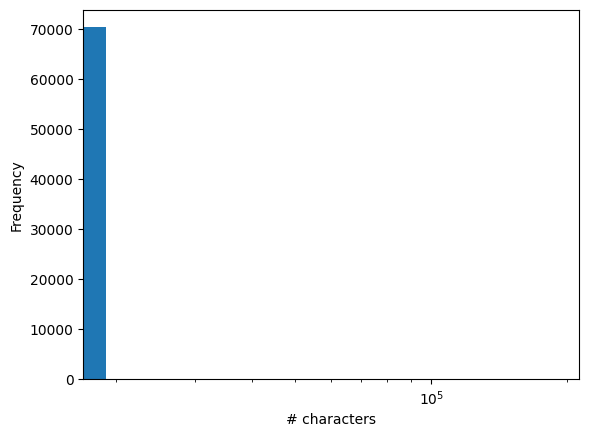

In [48]:
import matplotlib.pyplot as plt
plt.hist(res.sumChars.to_numpy())
plt.xlabel("# characters")
plt.ylabel("Frequency")
plt.xscale("log")

In [49]:
!curl https://2.bp.blogspot.com/-eGskF3n8_Ag/XE7F3P_de2I/AAAAAAAAHU8/WJw0un2nHqMGA8cFVtv_yFfpBVQJSYyVACK4BGAYYCw/s1600/Icon-Reddit.png > reddit.png
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

mask = np.array(Image.open("reddit.png"))
text = " ".join([i for i in kdf.selftext.to_numpy() if len(i) > 0 and i != "[removed]" and i!="[deleted]"])

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 76154  100 76154    0     0   165k      0 --:--:-- --:--:-- --:--:--  165k


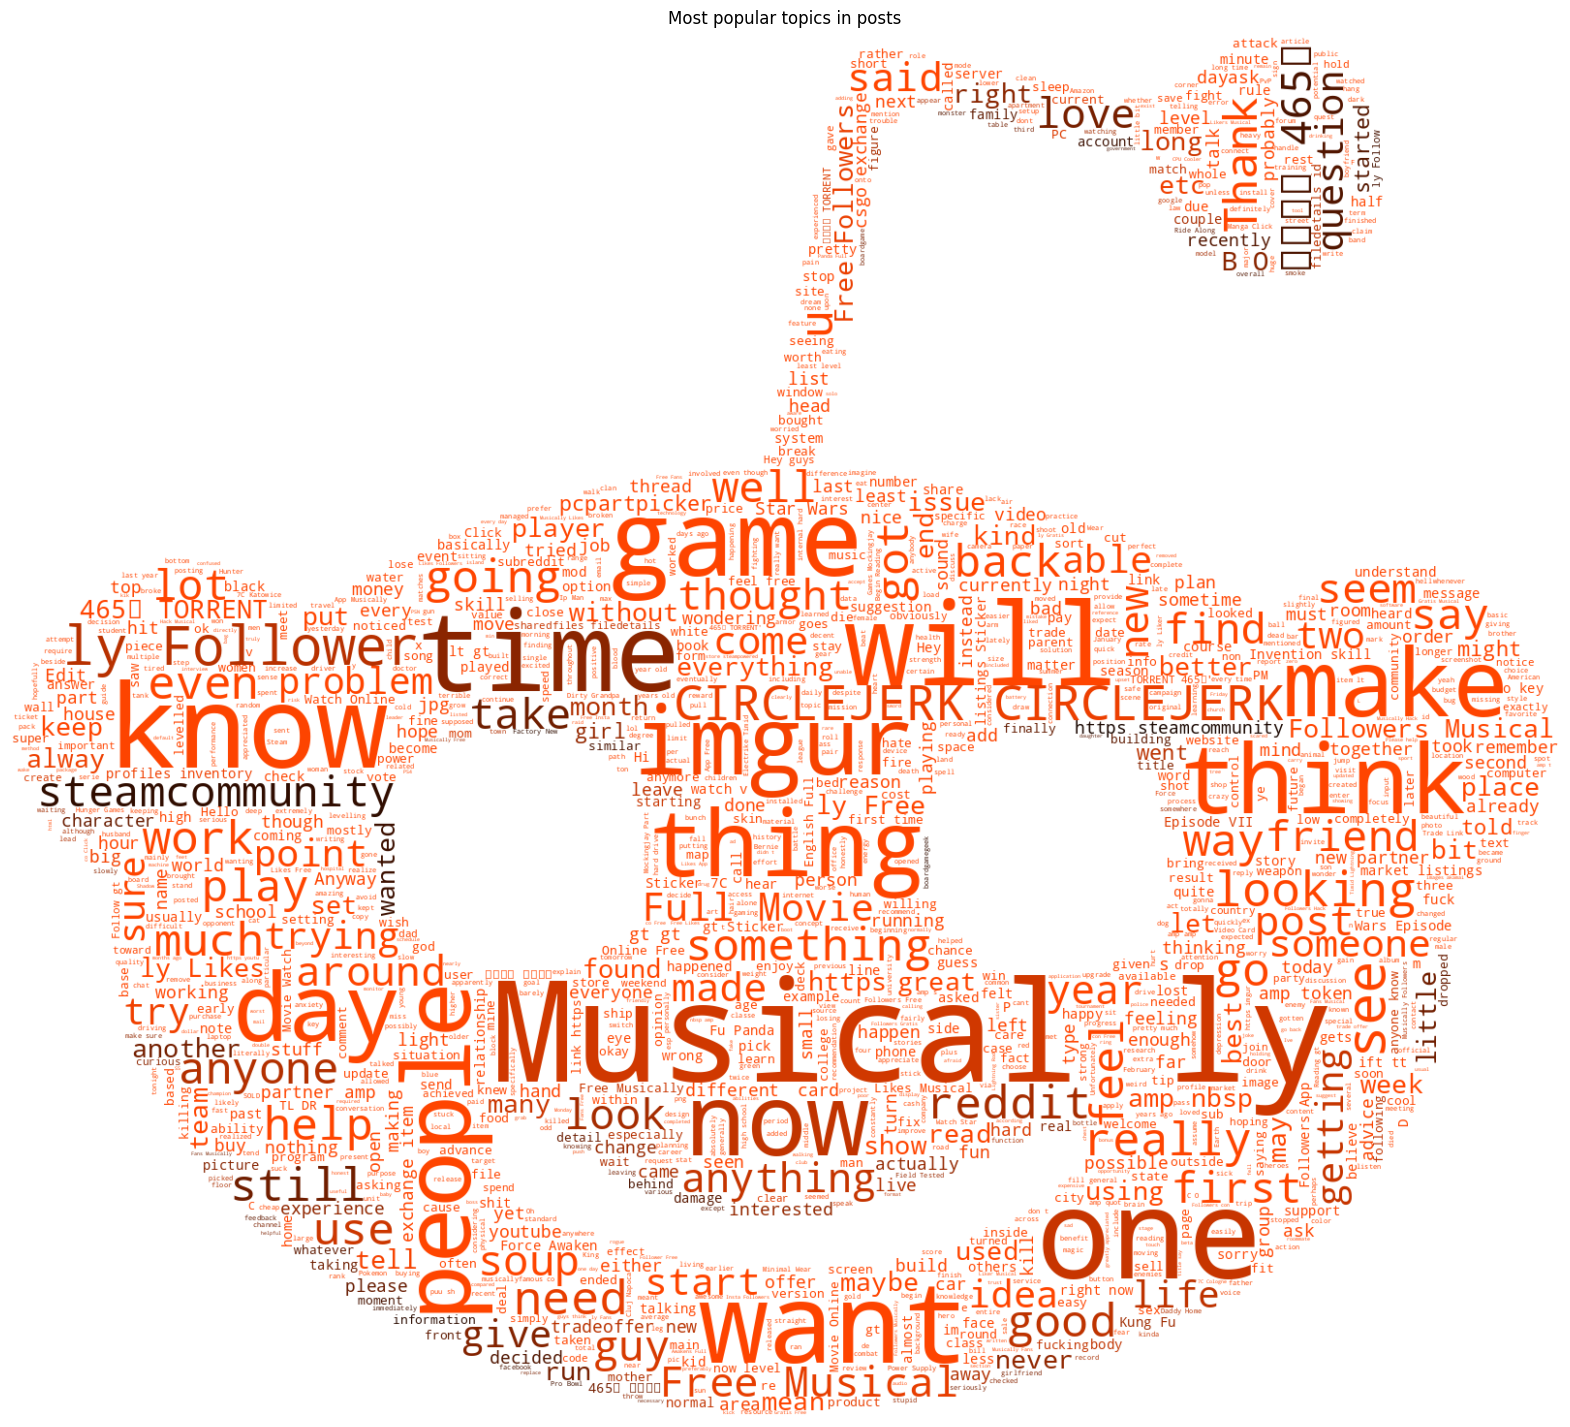

In [50]:
text = " ".join([i for i in kdf.selftext.to_numpy() if len(i) > 0 and i != "[removed]" and i!="[deleted]"])
wordcloud = WordCloud(max_words=5000, mask=~mask[:,:,0], background_color="white", mode="RGBA").generate(text)
# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=(20,20))
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.title("Most popular topics in posts")
plt.axis("off");

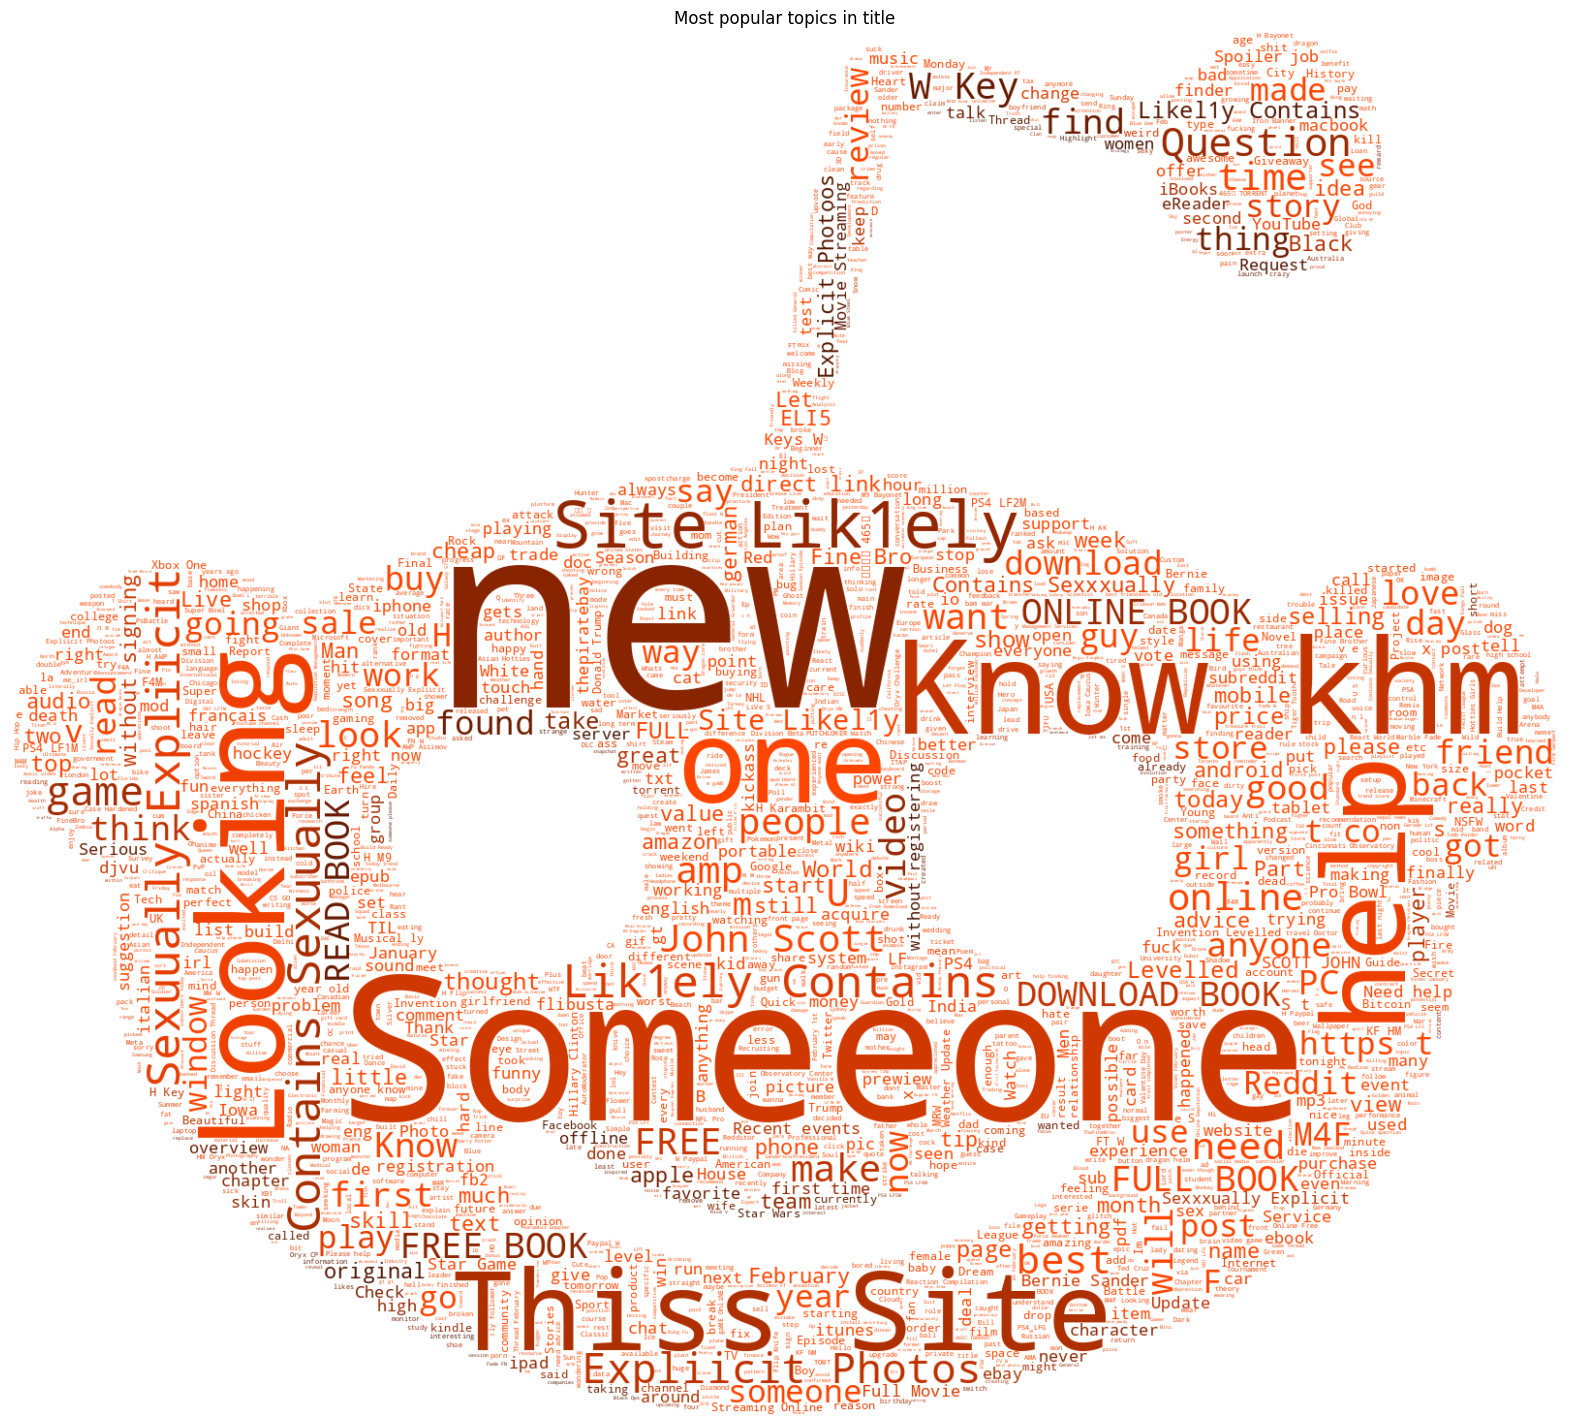

In [51]:
text = " ".join([i for i in kdf.title.to_numpy() if len(i) > 0 and i != "[removed]" and i!="[deleted]"])
wordcloud = WordCloud(max_words=5000, mask=~mask[:,:,0], background_color="white", mode="RGBA").generate(text)
# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=(20,20))
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.title("Most popular topics in title")
plt.axis("off");

--------


<font size=10 color=red>Assignment question</font>

Choose a subreddit you like and build a worldcloud using Koalas. Feel free to change the mask or the colors...

--------
Answer: